In [1]:
import numpy as np
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
#-- This block is only required on Google Colab
import pandas as pd
import matplotlib.pyplot as plt
# from google.colab import drive
# drive.mount('/content/drive')
%cd '/content/drive/MyDrive/glq_mpia'
#--
import contrastive_utils

/content/drive/MyDrive/glq_mpia


In [2]:
fl = np.load('./data/processed/ids.npz')
ids = fl['ids']
fl = np.load("./data/processed/imgs.npz")
imgs = fl["imgs"]

In [45]:
# Loading model
contrastor = contrastive_utils.Contrastor(
    contrastive_utils.load_augmentor(),
    contrastive_utils.load_encoder(n_filters_1=128, n_filters_2=256, n_filters_3=512),
    contrastive_utils.load_projector(input_size=512, n_nodes_1=256, n_nodes_3=128),
    temperature=0.1,
)
# Compiling model
contrastor.compile(
    optimizer=optimizers.SGD(learning_rate=3e-4, momentum=1e-5), run_eagerly=True
)

In [46]:
# Training model
history = contrastor.fit(
    contrastive_utils.normalise_imgs(imgs),
    batch_size=128,
    epochs=100,
    callbacks=[EarlyStopping(
        monitor="loss",
        mode="min",
        patience=5,
        verbose=1,
        min_delta=0.01
    )],
)
contrastor.save_weights('./models/contrastor', save_format='tf')

Epoch 1/100
52/52 [==============================] - 7s 130ms/step - loss: 5.5934
Epoch 2/100
52/52 [==============================] - 6s 123ms/step - loss: 5.5328
Epoch 3/100
52/52 [==============================] - 7s 130ms/step - loss: 5.5095
Epoch 4/100
52/52 [==============================] - 6s 118ms/step - loss: 5.4853
Epoch 5/100
52/52 [==============================] - 7s 130ms/step - loss: 5.3927
Epoch 6/100
52/52 [==============================] - 6s 119ms/step - loss: 4.8921
Epoch 7/100
52/52 [==============================] - 7s 132ms/step - loss: 4.3376
Epoch 8/100
52/52 [==============================] - 6s 116ms/step - loss: 3.9988
Epoch 9/100
52/52 [==============================] - 7s 127ms/step - loss: 3.8092
Epoch 10/100
52/52 [==============================] - 6s 116ms/step - loss: 3.6577
Epoch 11/100
52/52 [==============================] - 7s 128ms/step - loss: 3.5915
Epoch 12/100
52/52 [==============================] - 6s 116ms/step - loss: 3.4687
Epoch 13/100


In [47]:
# Forward passing the original images
encoded_imgs = contrastor.encoder(
    contrastive_utils.normalise_imgs(imgs[:, 2:-2, 2:-2, :])
).numpy()
encoded_imgs = np.array([enc_img / np.linalg.norm(enc_img) for enc_img in encoded_imgs])
np.savez_compressed('./data/processed/encoded_imgs', ids=ids, encoded_imgs=encoded_imgs)

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [49]:
fl = np.load('/content/drive/MyDrive/glq_mpia/data/processed/encoded_imgs.npz')
ids = fl['ids']
enc_imgs = fl['encoded_imgs']
hzq_df = pd.read_csv('/content/drive/MyDrive/glq_mpia/data/external/known_hzqs.csv')
hzq_cois = [coi for coi in hzq_df['COADD_OBJECT_ID']
           if str(coi) in ids]

In [50]:
embedding = TSNE(n_components=2).fit_transform(enc_imgs)

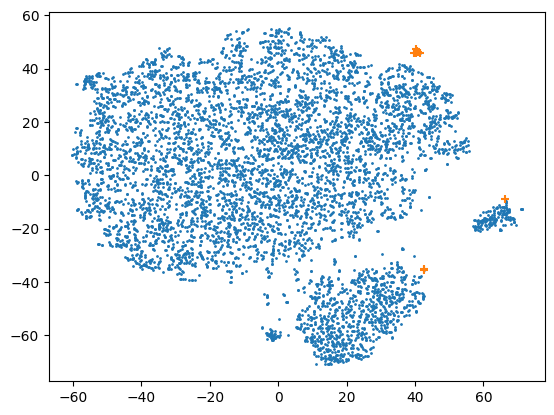

In [51]:
plt.scatter(
    embedding[:,0], embedding[:,1], s=1
)
plt.scatter(
    [embedding[ids.astype(int)==coi,0] for coi in hzq_cois],
    [embedding[ids.astype(int)==coi,1] for coi in hzq_cois],
    marker='+'
)
# plt.xlim(55,70)
# plt.ylim(-25,5)

In [52]:
import bokeh

In [56]:
def plot_simple_embedding(points):
    df = pd.DataFrame(index=ids.astype(int), columns=['x','y','url'])
    df['x'] = embedding[:,0]
    df['y'] = embedding[:,1]
    df['id'] = ids.astype(int)
    img_tooltip = "@{id}"
    P = bokeh.plotting.figure(width=600, height=600, tooltips=img_tooltip)
    P.circle('x', 'y', size=2, source=df)
    P.x('x','y',size=30, line_width=2, color='black', source = df.loc[hzq_cois])
    bokeh.plotting.output_notebook()
    bokeh.plotting.show(P)
    return P
P = plot_simple_embedding(embedding)